Implement a neural network for m-samples and n-features, as we discussed in class (both FP and BP), and for N layers in the hidden layer. Split the data (you can use the log. reg. data or any other one) and train your network with 70% of the data. Use 15% for validation and test your network with the remaining 15% of data. Report the evaluation metrics for the varying number of layers in the network. Plot the training loss curves.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy


df = pd.read_csv("archive/weather_forecast_data.csv")
df['Rain'] = df['Rain'].map({'rain': 1, 'no rain': 0})
df.dropna(inplace=True)

X = df[['Temperature', 'Humidity', 'Wind_Speed', 'Cloud_Cover', 'Pressure']].values
y = df['Rain'].values.reshape(-1, 1)

# Normalization
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X = (X - X_mean) / X_std

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.50, random_state=42)

X_train, y_train = X_train.T, y_train.T
X_val, y_val = X_val.T, y_val.T
X_test, y_test = X_test.T, y_test.T

In [3]:
# Activation functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

# Loss and accuracy
def compute_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-8, 1 - 1e-8)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def compute_accuracy(y_true, y_pred):
    preds = (y_pred > 0.5).astype(int)
    return np.mean(preds == y_true)

# Initialization
def initialize_parameters(layer_dims):
    parameters = {}
    np.random.seed(1)
    for l in range(1, len(layer_dims)):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters
def evaluation_metrics(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (TP + TN) / len(y_true)
    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    return np.array([[TN, FP], [FN, TP]])


In [4]:

def forward_propagation(X, parameters):
    caches = {'A0': X}
    A = X
    L = len(parameters) // 2
    for l in range(1, L):
        Z = parameters['W' + str(l)] @ A + parameters['b' + str(l)]
        A = relu(Z)
        caches['Z' + str(l)] = Z
        caches['A' + str(l)] = A
    ZL = parameters['W' + str(L)] @ A + parameters['b' + str(L)]
    AL = sigmoid(ZL)
    caches['Z' + str(L)] = ZL
    caches['A' + str(L)] = AL
    return AL, caches


def backward_propagation(X, Y, parameters, caches):
    grads = {}
    m = X.shape[1]
    L = len(parameters) // 2

    dZL = caches['A' + str(L)] - Y
    grads['dW' + str(L)] = (1/m) * dZL @ caches['A' + str(L-1)].T
    grads['db' + str(L)] = (1/m) * np.sum(dZL, axis=1, keepdims=True)

    for l in reversed(range(1, L)):
        dA = parameters['W' + str(l+1)].T @ dZL
        dZ = dA * relu_derivative(caches['Z' + str(l)])
        grads['dW' + str(l)] = (1/m) * dZ @ caches['A' + str(l-1)].T
        grads['db' + str(l)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        dZL = dZ

    return grads


def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(1, L+1):
        parameters['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        parameters['b' + str(l)] -= learning_rate * grads['db' + str(l)]
    return parameters



In [5]:
def create_batches(X, Y, batch_size):
    m = X.shape[1]
    permutation = np.random.permutation(m)
    X_shuffled = X[:, permutation]
    Y_shuffled = Y[:, permutation]
    batches = []

    num_batches = m // batch_size
    for i in range(num_batches):
        X_batch = X_shuffled[:, i*batch_size:(i+1)*batch_size]
        Y_batch = Y_shuffled[:, i*batch_size:(i+1)*batch_size]
        batches.append((X_batch, Y_batch))

    if m % batch_size != 0:
        X_batch = X_shuffled[:, num_batches*batch_size:]
        Y_batch = Y_shuffled[:, num_batches*batch_size:]
        batches.append((X_batch, Y_batch))

    return batches

# Model training
def model(X_train, y_train, X_val, y_val, layer_dims, learning_rate=0.01, epochs=1000, patience=20, batch_size=32):
    parameters = initialize_parameters(layer_dims)
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        batches = create_batches(X_train, y_train, batch_size)

        epoch_loss = 0
        for X_batch, y_batch in batches:
            AL, caches = forward_propagation(X_batch, parameters)
            loss = compute_loss(y_batch, AL)
            grads = backward_propagation(X_batch, y_batch, parameters, caches)
            parameters = update_parameters(parameters, grads, learning_rate)
            epoch_loss += loss * X_batch.shape[1]

        epoch_loss /= X_train.shape[1]

        # Validation loss
        AL_val, _ = forward_propagation(X_val, parameters)
        val_loss = compute_loss(y_val, AL_val)

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_parameters = copy.deepcopy(parameters)
            patience_counter = 0
        else:
            patience_counter += 1

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}. Best Val Loss: {best_val_loss:.4f}")
            break

    return best_parameters, train_losses, val_losses

In [6]:
def predict(X, parameters):
    AL, _ = forward_propagation(X, parameters)
    return (AL > 0.5).astype(int)


layers_list = [1, 2,3]
results = {}

for num_hidden_layers in layers_list:
    print(f"\nTraining network with {num_hidden_layers} hidden layers...")
    layer_dims = [X_train.shape[0]] + [12]*num_hidden_layers + [1]  # 16 neurons each hidden layer

    parameters, train_losses, val_losses = model(X_train, y_train, X_val, y_val, layer_dims, 
                                                 learning_rate=0.001, epochs=1000, batch_size=32)

    y_test_pred = predict(X_test, parameters)


    y_true = y_test.flatten()
    y_pred = y_test_pred.flatten()
    print(f"\nEvaluation for {num_hidden_layers} hidden layers:")
    conf_matrix = evaluation_metrics(y_true, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    results[num_hidden_layers] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'confusion_matrix': conf_matrix
    }




Training network with 1 hidden layers...
Epoch 0, Loss: 1.0901, Val Loss: 1.1313
Epoch 100, Loss: 0.2501, Val Loss: 0.2273
Epoch 200, Loss: 0.2005, Val Loss: 0.1790
Epoch 300, Loss: 0.1762, Val Loss: 0.1564
Epoch 400, Loss: 0.1611, Val Loss: 0.1430
Epoch 500, Loss: 0.1503, Val Loss: 0.1341
Epoch 600, Loss: 0.1416, Val Loss: 0.1271
Epoch 700, Loss: 0.1345, Val Loss: 0.1218
Epoch 800, Loss: 0.1287, Val Loss: 0.1176
Epoch 900, Loss: 0.1240, Val Loss: 0.1138

Evaluation for 1 hidden layers:
Accuracy:  0.9307
Precision: 0.7619
Recall:    0.6667
F1 Score:  0.7111
Confusion Matrix:
[[317  10]
 [ 16  32]]

Training network with 2 hidden layers...
Epoch 0, Loss: 0.7296, Val Loss: 0.6440
Epoch 100, Loss: 0.2175, Val Loss: 0.1941
Epoch 200, Loss: 0.1586, Val Loss: 0.1424
Epoch 300, Loss: 0.1333, Val Loss: 0.1194
Epoch 400, Loss: 0.1189, Val Loss: 0.1060
Epoch 500, Loss: 0.1092, Val Loss: 0.0976
Epoch 600, Loss: 0.1013, Val Loss: 0.0916
Epoch 700, Loss: 0.0942, Val Loss: 0.0877
Epoch 800, Loss: 0

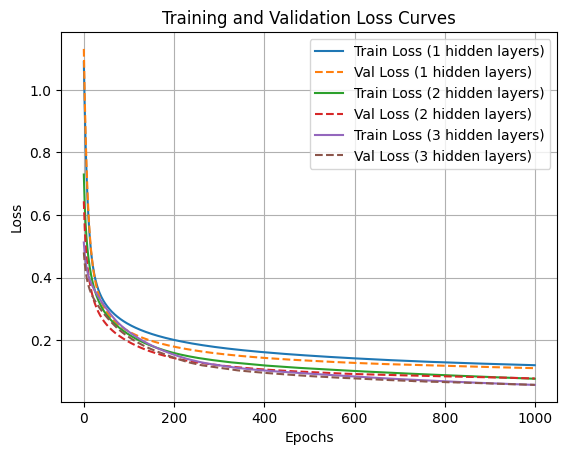

In [7]:
for num_hidden_layers, res in results.items():
    plt.plot(res['train_losses'], label=f'Train Loss ({num_hidden_layers} hidden layers)')
    plt.plot(res['val_losses'], linestyle='--', label=f'Val Loss ({num_hidden_layers} hidden layers)')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()